In [1]:
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset
import networkx as nx
from itertools import combinations
from scipy.spatial.distance import cosine, euclidean, chebyshev, jensenshannon

rng = np.random.default_rng(seed=1234)

In [2]:
# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("perspectiva-solution/embeddings-gdn-question-163")['train']
df = ds.to_pandas()
df = df[df.cluster_id != -1].sample(n=10000, random_state=1234) # Remove idea which were not clustered

In [3]:
# TODO Probably refactor as object since we keep passing personas around

def sim_from_dist(vec_a, vec_b, dist=chebyshev):
    return 1 / (1 + dist(vec_a, vec_b))

def gaussian_sim(vec_a, vec_b, sigma=0.1, dist=jensenshannon):
    return np.exp(
        -jensenshannon(vec_a, vec_b) / (2 * sigma**2)
    )

def characterize_node(idx, personas, id_col="cluster_title"):
    """Return common contributions of the community

    Args:
        idx (_type_): _description_
    """
    msk = df.contribution_id.isin(personas[idx])
    community_demands = df[msk].groupby(id_col)["cluster_title"].count().rename("cluster_count")
    return (community_demands / community_demands.sum()).sort_values(ascending=False)

    
n_clusters = df.cluster_title.nunique()
def node_to_vec(node, personas):
    char = characterize_node(node, personas, id_col="cluster_id")
    vec = np.zeros((n_clusters))
    for _, row in pd.DataFrame(char).reset_index().iterrows():
        vec[int(row.cluster_id)] = row.cluster_count
    return vec

def make_title(demands, topk=5):
    title = ""
    for row_idx in range(topk):
        try:
            row_value = demands.iloc[row_idx]
        except IndexError:
            return title
        demand = demands.index[row_idx]
        title += f"{demand} ({row_value * 100:.2f}%)\n"
    return title

def return_IoU(node_i, node_j, personas):
    contributions_i = personas[node_i]
    contributions_j = personas[node_j]

    demands_i = df.loc[df.contribution_id.isin(contributions_i), "cluster_title"].unique()
    demands_j = df.loc[df.contribution_id.isin(contributions_j), "cluster_title"].unique()
    intersection = set(demands_i).intersection(set(demands_j))
    union = set(demands_i).union(set(demands_j))
    return len(intersection) / len(union)


N_PERMS = 1000

def random_frequency_vec(true_vec, rng):
    n_nonzero = np.count_nonzero(true_vec)
    array_indices = tuple(range(n_clusters))
    for _ in range(N_PERMS):
        null_vec = np.zeros_like(true_vec)
        msk = rng.choice(array_indices, size=n_nonzero)
        null_vec[msk] = rng.integers(0, 100, size=n_nonzero)
        null_vec = null_vec / null_vec.sum()
        yield null_vec


def test_similarity(vec_a, vec_b):
    null_sims = []
    iter_a = random_frequency_vec(vec_a, rng)
    iter_b = random_frequency_vec(vec_b, rng)

    for null_vec_a, null_vec_b in zip(iter_a, iter_b):
        null_sims.append(1 / (1 + euclidean(null_vec_a, null_vec_b)))
    null_sims = np.array(null_sims)

    realised_sim = 1/(1 + euclidean(vec_a, vec_b))
    pvalue_right = (np.sum(null_sims > realised_sim)+ 1) / (N_PERMS + 1)
    pvalue_left = (np.sum(null_sims < realised_sim)+ 1) / (N_PERMS + 1)
    pvalue = np.minimum(pvalue_right, pvalue_left) * 2

    #if pvalue * n_tests >= 0.05:
    #    fig, ax = plt.subplots()
    #    h = ax.hist(null_sims, histtype="step", label=f"Null scores, {N_PERMS} permutations")
    #    ax.vlines(realised_sim, ymin=0, ymax=np.max(h[0]), color="red", label="Realised score")
    #    ax.legend(loc="upper left")
    #    ax.set_title(
    #        f"""
    #        pvalue = {pvalue} (two sided)
    #        """
    #    )
    #    plt.show()
    return pvalue

def find_bridge(node_pair, personas, topk=5):
    common_ideas = pd.merge(
        characterize_node(node_pair[0], personas)[:topk],
        characterize_node(node_pair[1], personas)[:topk],
        how="inner",
        on="cluster_title"
    ).reset_index()
    common_ideas["sum_freq"] = common_ideas["cluster_count_x"] + common_ideas["cluster_count_y"]
    bridge = common_ideas.sort_values(by="sum_freq", ascending=False).loc[0, "cluster_title"]
    return bridge



In [4]:
G = nx.Graph()
G.add_nodes_from(df.contribution_id) # A node is a contribution

# Add edge if two nodes belong to the same cluster
for title, subdf in df.groupby("cluster_title"):
    edges = tuple(combinations(subdf.contribution_id.to_list(), 2))
    for edge in edges:
        if G.has_edge(*edge):
            G.edges[*edge]["weight"] += 1
        else:
            G.add_edge(*edge, weight=1)

In [5]:
partition = nx.community.louvain_communities(
    G, weight="weight", resolution=1, seed=2025
)

In [6]:
# Big partitions could be personas
personas = []
threshold = 1#len(df) // 500
for node_set in partition:
    if len(node_set) >= threshold:
        personas.append(node_set)


In [7]:
EDGE_SCALE_FACTOR = 0.1

# Graph of Louvain communities
H = nx.Graph()
H.add_nodes_from(range(len(personas)), borderWidth=0.5)
n_tests = len(tuple(combinations(H.nodes, 2)))

weights = []
for node_pair in combinations(H.nodes, 2):
    vec_a, vec_b = node_to_vec(node_pair[0], personas), node_to_vec(node_pair[1], personas)

    #pvalue = test_similarity(vec_a, vec_b, n_tests)
    #if pvalue >= 0.05:
    #    print("Edge not significant")
    #    continue
    
    #sim = 1 / (1+euclidean(vec_a, vec_b))
    #sim = gaussian_sim(vec_a, vec_b, dist=jensenshannon, sigma=1/2)
    try:
        bridge = find_bridge(node_pair, personas)
    except KeyError: # If there's not a frequent common idea, skip edge
        continue

    sim = sim_from_dist(vec_a, vec_b, dist=jensenshannon)
    weights.append(sim)
    if sim < 0.5:
        color = "gray"
    else:
        color = "black"

    H.add_edge(
        *node_pair,
        value=sim * EDGE_SCALE_FACTOR,
        #hidden=False,
        color=color,
        title=bridge
        #title="\n".join(return_intersection(1, 2)) # TODO I will return
    )

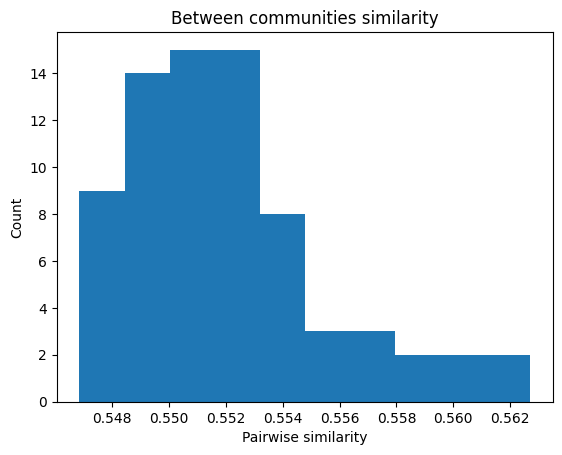

In [8]:
plt.hist(np.array(weights))
plt.title("Between communities similarity")
plt.xlabel("Pairwise similarity")
plt.ylabel("Count")
plt.show()

In [9]:
max_comm_size = max((len(p) for p in personas))
size_factor = 100 / max_comm_size
for community in H.nodes:
    community_demands = characterize_node(community, personas)
    H.nodes[community]["title"] = make_title(community_demands)
    H.nodes[community]["size"] = len(personas[community]) * size_factor

In [10]:
from pyvis.network import Network
nt = Network("500px", "1000px")
nt.force_atlas_2based()
nt.from_nx(H)
nt.toggle_physics(True)
nt.show_buttons(filter_=["physics"])


nt.options["interaction"].__dict__["selectConnectedEdges"] = True

nt.show("communities.html", notebook=False)

communities.html
